In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import torchvision
from IPython.display import clear_output

CPU = False
MPS = False
CUDA = True

device = torch.device('cpu')
mps = False
if MPS:
  device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
  mps = torch.backends.mps.is_available()
if CUDA:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  cuda = torch.cuda.is_available()
if CPU:
  device = torch.device('cpu')
  mps = False

In [2]:
IMAGE_SIZE = 28 * 28
BATCH_SIZE = 128
EPOCHS = 300000
LEARNING_RATE_GEN = 0.05
LEARNING_RATE_DIS = 0.005
NOISE_DIM = 10

In [3]:
MNIST = torchvision.datasets.MNIST('.', train=True, download=True)
X_train = (MNIST.data.reshape(-1, IMAGE_SIZE) / 255).to(device)
y_train = (MNIST.targets).to(device)

In [4]:
activation = nn.LeakyReLU(0.2, inplace=True)
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.normal_(m.weight, mean=0, std=0.1)

def LinearBlock(hidden_size):
  blockfn = lambda input_size, output_size : [
    nn.Linear(input_size, output_size),
    nn.Dropout(p=0.2),
    activation
  ]
  return [
    blockfn(hidden_size[i//3], hidden_size[i//3+1])[i%3] for i in range(len(hidden_size)*3-3)
  ]

class Generator(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: list):
    super().__init__()
    self.input_size = input_size
    self.model = nn.Sequential(
      nn.Linear(input_size, hidden_size[0]),
      activation,
      *LinearBlock(hidden_size),
      nn.Linear(hidden_size[-1], output_size),
      nn.Sigmoid() # from 0 to 1
    )
    
  def forward(self, x):
    return self.model(x.view(-1, self.input_size))
  
class Discriminator(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: list):
    super().__init__()
    self.input_size = input_size
    self.ll = nn.Sequential(
      nn.Linear(input_size, hidden_size[0]),
      activation,
      *LinearBlock(hidden_size),
      nn.Linear(hidden_size[-1], output_size),
      nn.Sigmoid() # from 0 to 1
    )

  def forward(self, x):
    return self.ll(x.view(-1, self.input_size))

In [5]:
generator_loss = nn.BCELoss()
discriminator_loss = nn.BCELoss()
generator = Generator(NOISE_DIM, IMAGE_SIZE, [512, 512, 256])
discriminator = Discriminator(IMAGE_SIZE, 1, [512, 256])
generator.apply(init_weights)
discriminator.apply(init_weights)
generator.to(device)
discriminator.to(device)

Discriminator(
  (ll): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [6]:
generator.load_state_dict(torch.load('model/generator-small-dropout.pth',map_location=device))
discriminator.load_state_dict(torch.load('model/discriminator-small-dropout.pth', map_location=device))

<All keys matched successfully>

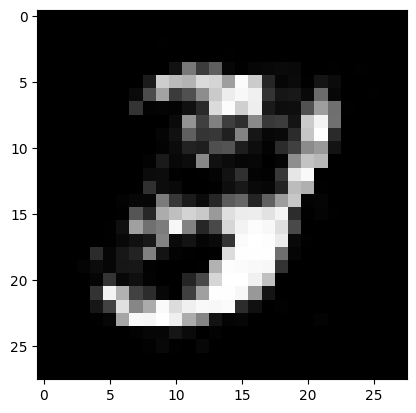

Epoch 43000/300000 disc_loss: 0.11350338906049728
fake_probabliity: 0.06147509440779686 real_probability: 0.9083257913589478
Epoch 43000/300000 gen_loss: 3.4552464485168457


KeyboardInterrupt: 

In [6]:
k0 = 5
k = k0
m = 1
optimizer_G = optim.SGD(generator.parameters(), lr=LEARNING_RATE_GEN)
optimizer_D = optim.SGD(discriminator.parameters(), lr=LEARNING_RATE_DIS)
for epoch in range(1, EPOCHS+1):
  for _ in range(k):
    optimizer_D.zero_grad()
    z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
    fake_output = generator(z)
    real_output = X_train[np.random.choice(X_train.shape[0], BATCH_SIZE)]
    loss = discriminator_loss(discriminator(real_output), torch.ones(BATCH_SIZE, 1).to(device))
    loss += discriminator_loss(discriminator(fake_output), torch.zeros(BATCH_SIZE, 1).to(device))
    loss /= 2
    loss.backward()
    optimizer_D.step()
    dict_loss = loss.item()


  if epoch % 1000 == 0:
    z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
    fake_output = generator(z)
    real_output = X_train[np.random.choice(X_train.shape[0], BATCH_SIZE)]
    loss = discriminator_loss(discriminator(real_output), torch.ones(BATCH_SIZE, 1).to(device))
    loss += discriminator_loss(discriminator(fake_output), torch.zeros(BATCH_SIZE, 1).to(device))
    loss /= 2
    dict_loss = loss.item()

    clear_output(wait=True)
    z = torch.randn(1, NOISE_DIM).to(device)
    fake_output = generator(z)
    plt.imshow(fake_output.view(28, 28).to('cpu').detach().numpy(), cmap='gray')
    plt.savefig(f'training/{epoch}.png')
    plt.show()
    print(f'Epoch {epoch}/{EPOCHS} disc_loss: {loss.item()}')
    print(f'fake_probabliity: {discriminator(fake_output).mean()} real_probability: {discriminator(real_output).mean()}')
  for _ in range(m):
    optimizer_G.zero_grad()
    z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
    fake_output = generator(z)
    loss = generator_loss(discriminator(fake_output), torch.ones(BATCH_SIZE, 1).to(device))
    asdf = (discriminator(fake_output))
    loss.backward()
    optimizer_G.step()
  if epoch % 1000 == 0:
    print(f'Epoch {epoch}/{EPOCHS} gen_loss: {loss.item()}')
  if epoch % 10000 == 0:
    torch.save(generator.state_dict(), 'training/latest-gen.pth')
    torch.save(discriminator.state_dict(), 'training/latest-disc.pth')
    

z = torch.randn(1, NOISE_DIM).to(device)
fake_output = generator(z)
plt.imshow(fake_output.view(28, 28).to('cpu').detach().numpy(), cmap='gray')
plt.show()

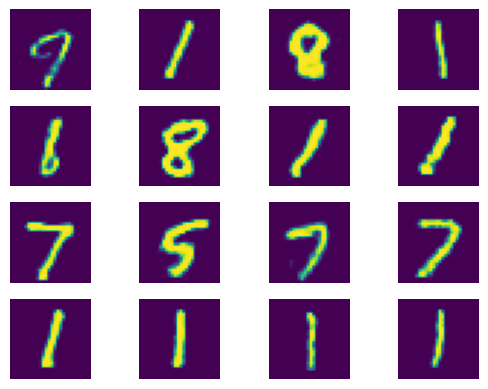

In [13]:
images = []
for _ in range(4*4):
  z = torch.randn(1, NOISE_DIM).to(device)
  fake_output = generator(z)
  images.append(fake_output.view(28, 28).to('cpu').detach().numpy())

for idx, image in enumerate(images):
  plt.subplot(4,4, idx+1)
  plt.axis('off')
  plt.imshow(image)
plt.show()

In [9]:
torch.save(generator.state_dict(), 'model/generator-small-dropout.pth')
torch.save(discriminator.state_dict(), 'model/discriminator-small-dropout.pth')

In [ ]:
torch.save(generator, 'model/generator_model.pth')

In [ ]:
loaded_gen = Generator(NOISE_DIM, IMAGE_SIZE, [128, 256, 256, 512, 1024], None)

In [ ]:
loaded_gen.load_state_dict(torch.load('model/generator.pth'))
loaded_gen.to(device)

In [ ]:
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
fake_output = loaded_gen(z)
loss = discriminator_loss(discriminator(fake_output), torch.zeros(BATCH_SIZE, 1).to(device))
loss

In [ ]:
z = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
fake_output = generator(z)
loss = discriminator_loss(discriminator(fake_output), torch.zeros(BATCH_SIZE, 1).to(device))
loss

In [ ]:
discriminator(fake_output).mean()

In [ ]:
discriminator(real_output).mean()

In [ ]:
z = torch.randn(1, NOISE_DIM).to(device)
fake_output = generator(z)
plt.imshow(fake_output.view(28, 28).to('cpu').detach().numpy(), cmap='gray')
plt.show()

In [ ]:
fake_output = generator(z)
real_output = X_train[np.random.choice(X_train.shape[0], BATCH_SIZE)]
loss = discriminator_loss(real_output, fake_output, discriminator)
loss

In [ ]:
generator = Generator(NOISE_DIM, IMAGE_SIZE, [256, 512], None)
discriminator = Discriminator(IMAGE_SIZE, 1, [512, 256], None)
z = torch.randn(BATCH_SIZE, NOISE_DIM)
fake_output = generator(z)
torch.mean(torch.log(discriminator(fake_output)))

In [ ]:
discriminator.ll

In [ ]:
X = torch.normal(0, 1, (512, 64))
X[0]

In [ ]:
model = Generator(10, 10, [10, 10, 10])
model(torch.rand(10))